In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# shap
import shap

# lime
import lime
import lime.lime_tabular
import numpy as np

from Interpretable_ML.src.data.DexTradePreprocessor import DexTradePreprocessor
from Interpretable_ML.src.features.DexTradeFeatureEngineer import DexTradeFeatureEngineer
from Interpretable_ML.src.models.OfflineAnomalyPipeline import OfflineAnomalyPipeline

# Pipeline Explanation:

In this work i take real world example: the task is to implement clusterization of crypto wallet trades and give the interpretation to user

## Data preparation

In [99]:
data_path = '../dataset/new_wallet.csv'

In [100]:
df = pd.read_csv(data_path)
df.head(5)

transaction_hash             timestamp  \
0  0xebeb4c1a24ca9a21545bf1a3a291a7686f5d9d86dc94...  2023-09-23T18:34:11Z   
1  0xfd4e65fe8a9e9e9a1238b805ee3472c3c9839ece6d1c...  2023-07-27T07:12:47Z   
2  0xa5623e61f756f32556ce33f30a5dbc642caa998cc433...  2023-07-20T16:15:23Z   
3  0x93e37f66f63ee7a850c51674d20b98d221fee51c729b...  2023-07-10T09:47:47Z   
4  0x9ece7238de59e902bbb96da252e6de59c85d2f5f0555...  2023-06-19T13:16:11Z   

        gas    gas_usd  max_priority_fee_per_gas  max_priority_fee_usd  \
0  0.001505   2.400713              1.000000e-10          1.594690e-07   
1  0.004552   8.534638              1.000000e-10          1.874920e-07   
2  0.004539   8.576635              3.000000e-10          5.668110e-07   
3  0.042386  78.914358              2.000000e-07          3.723640e-04   
4  0.003889   6.731569              1.000000e-10          1.731120e-07   

  aggregator_name exchange_name contract_version  \
0             NaN       uniswap               v3   
1             NaN       uniswap               v3   
2             NaN       uniswap               v3   
3             NaN       uniswap               v3   
4             NaN       uniswap               v3   

                  sell_token_contract_address  ... sell_token_amount_usd  \
0  0x6982508145454Ce325dDbE47a25d4ec3d2311933  ...           5577.670000   
1  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2  ...          65622.900000   
2  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2  ...           8119.647000   
3  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2  ...          18614.200000   
4  0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48  ...         101801.532085   

  sell_token_verified                  buy_token_contract_address  \
0                True  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   
1                True  0x6982508145454Ce325dDbE47a25d4ec3d2311933   
2                True  0x6982508145454Ce325dDbE47a25d4ec3d2311933   
3                True  0x6982508145454Ce325dDbE47a25d4ec3d2311933   
4                True  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   

   buy_token_symbol  buy_token_name  buy_token_amount buy_token_price  \
0              WETH   Wrapped Ether      3.500000e+00     1593.620000   
1              PEPE            Pepe      4.824308e+10        0.000001   
2              PEPE            Pepe      5.365217e+09        0.000002   
3              PEPE            Pepe      1.260401e+10        0.000001   
4              WETH   Wrapped Ether      5.882373e+01     1730.620000   

  buy_token_amount_usd buy_token_verified  is_mev_bot_int  
0          5577.670000               True               0  
1         65622.916858               True               0  
2          8119.647000               True               0  
3         18559.763254               True               0  
4        101801.532085               True               0  

[5 rows x 24 columns]

## Run preprocessing and feature engineering

In [101]:
pipe = OfflineAnomalyPipeline([
    ('preprocessor', DexTradePreprocessor(
        columns=[
            'timestamp',
            'sell_token_amount_usd',
            'buy_token_amount_usd',
            'sell_token_name',
            'buy_token_name',
            'exchange_name',
            'buy_token_verified',
            'sell_token_verified',
            'gas',
            'max_priority_fee_per_gas'
        ]
        )),
    ('feature_engineering', DexTradeFeatureEngineer(window_length=10))
    ])

df_transformed = pipe.fit_predict(df)

In [104]:
df_transformed.head(5)

sell_token_amount_usd  buy_token_amount_usd       gas  \
0          126899.880000         126880.283804  0.013042   
1            1500.114000           1500.114000  0.004815   
2          143197.535260         142813.089473  0.047115   
3           28477.679334          28335.999338  0.006371   
4           34900.353298          34893.080169  0.010649   

   max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
0              5.000000e-09            2           19           0   
1              1.500000e-09            1            9           0   
2              2.000000e-07            1           12           0   
3              1.500000e-09            3            8           0   
4              1.500000e-09            0           16           0   

   sell_to_buy_ratio  buy_to_sell_ratio  sell_buy_difference  ...  \
0           1.000154           0.999846            19.596196  ...   
1           1.000000           1.000000             0.000000  ...   
2           1.002692           0.997315           384.445787  ...   
3           1.005000           0.995025           141.679997  ...   
4           1.000208           0.999792             7.273129  ...   

   buy_token_name_Pepe  buy_token_name_Turbo  buy_token_name_USD Coin  \
0                  0.0                   0.0                      0.0   
1                  0.0                   0.0                      0.0   
2                  0.0                   0.0                      0.0   
3                  0.0                   0.0                      0.0   
4                  0.0                   0.0                      0.0   

   buy_token_name_Wrapped Ether  both_tokens_verified  neither_token_verified  \
0                           0.0                     1                       0   
1                           1.0                     1                       0   
2                           1.0                     1                       0   
3                           0.0                     1                       0   
4                           1.0                     1                       0   

   gas_ratio_sell  gas_ratio_buy  max_priority_fee_per_gas_ration_gas  \
0    1.027769e-07   1.027928e-07                         3.833657e-07   
1    3.209848e-06   3.209848e-06                         3.115175e-07   
2    3.290210e-07   3.299067e-07                         4.244933e-06   
3    2.237266e-07   2.248453e-07                         2.354339e-07   
4    3.051377e-07   3.052013e-07                         1.408528e-07   

   total_fee  
0   0.013042  
1   0.004815  
2   0.047115  
3   0.006371  
4   0.010649  

[5 rows x 36 columns]

In [108]:
X_train = df_transformed.select_dtypes(include=np.number).copy()
X_train = X_train[['sell_token_amount_usd', 'buy_token_amount_usd', 'gas',
       'max_priority_fee_per_gas', 'day_of_week', 'hour_of_day', 'is_weekend',
       'sell_to_buy_ratio']]

In [109]:
train_value = X_train.copy().values
min_max_scaler = MinMaxScaler()
train_scaled = min_max_scaler.fit_transform(train_value)
train_df_scaled = pd.DataFrame(train_scaled, columns=X_train.columns)
train_df_scaled.head(5)

sell_token_amount_usd  buy_token_amount_usd       gas  \
0               0.886150              0.888399  0.256794   
1               0.010152              0.010179  0.077338   
2               1.000000              1.000000  1.000000   
3               0.198607              0.198150  0.111280   
4               0.243474              0.244079  0.204598   

   max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
0                    0.0250     0.333333     0.818182         0.0   
1                    0.0075     0.166667     0.363636         0.0   
2                    1.0000     0.166667     0.500000         0.0   
3                    0.0075     0.500000     0.318182         0.0   
4                    0.0075     0.000000     0.681818         0.0   

   sell_to_buy_ratio  
0           0.075836  
1           0.066009  
2           0.237301  
3           0.384166  
4           0.079272

## Run clusterization via kmeans algorithm

In [111]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_df_scaled)
    distortions.append(kmeanModel.inertia_)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

Choose num of clusters

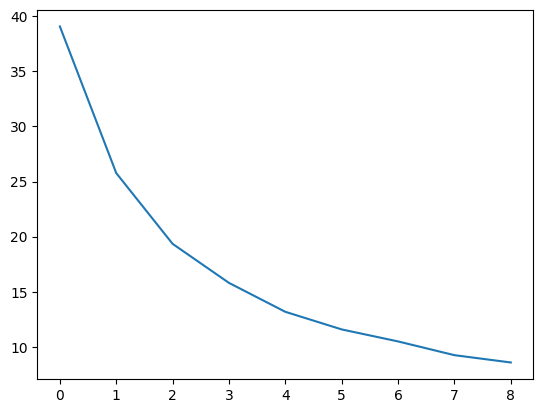

In [112]:
plt.plot(distortions)

#### For the interpretation we train tree model on the kmeans outputs

In [114]:
kmeanModel = KMeans(n_clusters=3)
y = kmeanModel.fit(train_df_scaled).labels_

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [115]:
clf = RandomForestClassifier(max_depth=2)
clf.fit(X_train, y)

RandomForestClassifier(max_depth=2)

## Check data

In [123]:
df = X_train.copy()
df['Cluster'] = y
df.head(5)

sell_token_amount_usd  buy_token_amount_usd       gas  \
0          126899.880000         126880.283804  0.013042   
1            1500.114000           1500.114000  0.004815   
2          143197.535260         142813.089473  0.047115   
3           28477.679334          28335.999338  0.006371   
4           34900.353298          34893.080169  0.010649   

   max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
0              5.000000e-09            2           19           0   
1              1.500000e-09            1            9           0   
2              2.000000e-07            1           12           0   
3              1.500000e-09            3            8           0   
4              1.500000e-09            0           16           0   

   sell_to_buy_ratio  Cluster  
0           1.000154        0  
1           1.000000        1  
2           1.002692        0  
3           1.005000        1  
4           1.000208        1

In [161]:
df[df['Cluster'] == 0]

sell_token_amount_usd  buy_token_amount_usd       gas  \
0           126899.880000         126880.283804  0.013042   
2           143197.535260         142813.089473  0.047115   
16          118001.030029         117982.880862  0.017814   
17           98618.222299          98079.267481  0.014670   
25          100659.019690          99990.000000  0.017636   
27          106114.387500         106147.647100  0.015137   
51           85941.801962          85941.800000  0.005680   
54           72209.200000          72209.202615  0.006689   
55          101945.952889         101946.314668  0.007209   
56          101801.532085         101801.532085  0.003889   

    max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
0               5.000000e-09            2           19           0   
2               2.000000e-07            1           12           0   
16              1.000000e-07            3           20           0   
17              1.000000e-07            3           20           0   
25              1.000000e-07            2           16           0   
27              1.000000e-07            2           19           0   
51              1.000000e-10            2           22           0   
54              1.000000e-10            0           20           0   
55              1.000000e-10            0            1           0   
56              1.000000e-10            0           13           0   

    sell_to_buy_ratio  Cluster  
0            1.000154        0  
2            1.002692        0  
16           1.000154        0  
17           1.005495        0  
25           1.006691        0  
27           0.999687        0  
51           1.000000        0  
54           1.000000        0  
55           0.999996        0  
56           1.000000        0

In [162]:
df[df['Cluster'] == 1]

sell_token_amount_usd  buy_token_amount_usd       gas  \
1             1500.114000           1500.114000  0.004815   
3            28477.679334          28335.999338  0.006371   
4            34900.353298          34893.080169  0.010649   
5            32996.271285          32959.757207  0.003254   
6               46.887932             46.887932  0.001270   
7            10705.723311          10652.461006  0.014479   
8            16352.487389          16350.432719  0.012475   
9            12788.771465          12725.145736  0.014507   
11           17799.881979          17799.881979  0.012971   
12            1926.847125           1926.847125  0.016639   
15             114.755654            114.373721  0.016459   
19             174.770490            173.564754  0.015795   
20           38152.071631          38152.071631  0.014001   
21           17570.505984          17588.751891  0.013484   
22            1588.811717           1588.811717  0.013494   
23           51337.705095          51337.705095  0.013519   
24           50212.072489          49995.000000  0.016942   
26            6162.780318           6123.775000  0.015550   
28              55.652766             54.847702  0.015790   
30            1909.989147           1903.932375  0.003815   
33           36528.000000          36528.056555  0.017397   
34            5479.200000           5479.200000  0.014120   
35           54803.700000          54799.829830  0.018360   
36           18227.800000          18227.800000  0.005971   
37            3092.759000           3092.759000  0.006764   
38           18885.198392          18885.198392  0.009809   
39           18906.576000          18906.584578  0.010859   
40            4664.332876           4664.332876  0.011391   
41            5031.950000           5031.950000  0.010025   
43           18029.400000          18029.101585  0.007836   
44            1803.020000           1803.749746  0.007690   
45           18561.600000          18561.600000  0.014984   
46            4511.124611           4511.300000  0.005876   
47            1085.502000           1085.502000  0.004535   
48            2339.480000           2339.478790  0.003188   
50           20867.330000          20867.330000  0.003473   
57           18614.200000          18559.763254  0.042386   
58            8119.647000           8119.647000  0.004539   
59           65622.900000          65622.916858  0.004552   

    max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
1               1.500000e-09            1            9           0   
3               1.500000e-09            3            8           0   
4               1.500000e-09            0           16           0   
5               1.500000e-09            4           20           0   
6               1.500000e-09            4           20           0   
7               1.000000e-07            4           13           0   
8               1.000000e-07            3           21           0   
9               1.000000e-07            4            1           0   
11              1.000000e-07            1           15           0   
12              1.000000e-07            4           19           0   
15              1.000000e-07            0            1           0   
19              1.000000e-07            1            1           0   
20              1.000000e-07            3           23           0   
21              1.000000e-07            2           16           0   
22              1.000000e-07            4            1           0   
23              1.000000e-07            4           20           0   
24              1.000000e-07            4           20           0   
26              1.000000e-07            2           18           0   
28              1.000000e-07            3           18           0   
30              1.000000e-10            3           23           0   
33              5.958260e-10            0           20           0   
34              5.60612

In [163]:
df[df['Cluster'] == 2]

sell_token_amount_usd  buy_token_amount_usd       gas  \
10             755.699325            755.614409  0.012163   
13           59703.702660          59703.702660  0.016507   
14           91457.674768          91000.000000  0.017637   
18           18081.129253          17991.173386  0.015037   
29             654.034659            654.034659  0.004000   
31           40049.827698          40025.713542  0.011645   
32          109940.369820         109939.211850  0.005316   
42           54183.000000          54183.000000  0.006055   
49            9147.900000           9145.572751  0.003251   
52           25667.416702          25667.415000  0.007449   
53           10053.773433          10053.773433  0.002980   
60            5577.670000           5577.670000  0.001505   

    max_priority_fee_per_gas  day_of_week  hour_of_day  is_weekend  \
10              1.000000e-07            5           19           1   
13              1.000000e-07            5           19           1   
14              1.000000e-07            5           19           1   
18              1.000000e-07            5           19           1   
29              1.000000e-10            6           16           1   
31              1.000000e-10            5           21           1   
32              1.000000e-10            5           22           1   
42              1.000000e-10            6           17           1   
49              1.000000e-10            5           13           1   
52              1.000000e-10            6           18           1   
53              1.000000e-10            6           22           1   
60              1.000000e-10            5           18           1   

    sell_to_buy_ratio  Cluster  
10           1.000112        2  
13           1.000000        2  
14           1.005029        2  
18           1.005000        2  
29           1.000000        2  
31           1.000602        2  
32           1.000011        2  
42           1.000000        2  
49           1.000254        2  
52           1.000000        2  
53           1.000000        2  
60           1.000000        2

## Interpretation

Explanation: Lets interpret the clusterization

In [117]:
feature_names = X_train.columns
class_names = list(map(str, set(y)))

### Shap values

In [116]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

##### Analyze global interpretation (for all predictions)

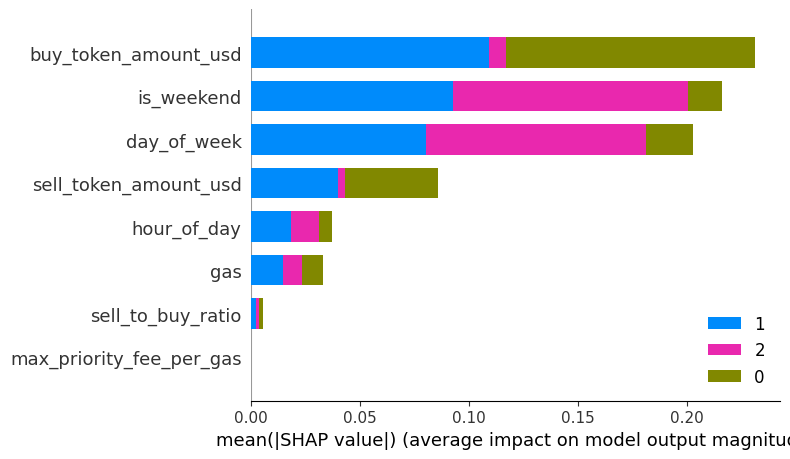

In [118]:
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names=class_names, feature_names = feature_names)

##### Analyze local interpretation (for soncrete prediction)

For example, analyze the 0 and 1 trades clusterization

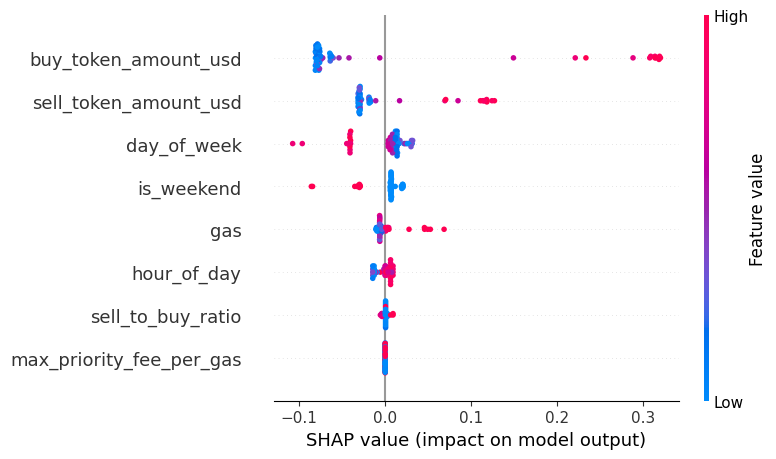

In [126]:
# Trade with 0 idx
shap.summary_plot(shap_values[0], X_train.values, feature_names = feature_names)

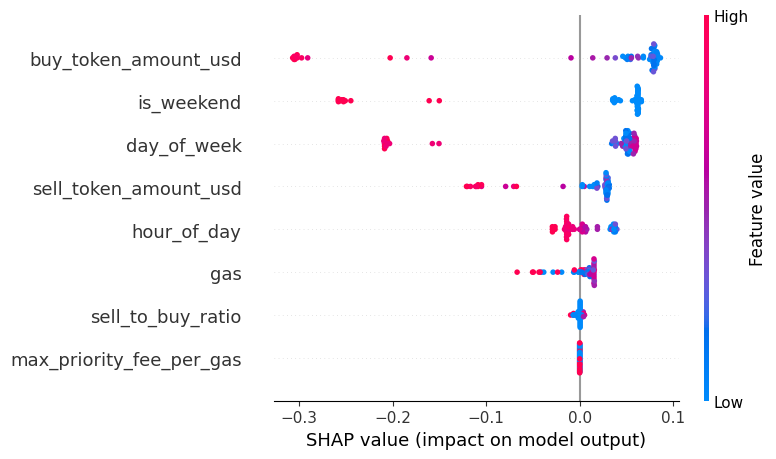

In [127]:
# Trade with 1 idx
shap.summary_plot(shap_values[1], X_train.values, feature_names = feature_names)

### LIME

In [142]:
# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=feature_names, 
    class_names=class_names, 
    mode='classification'
)
predict_fn_rf = lambda x: clf.predict_proba(x).astype(float)

In [175]:
# Choose instance
choosen_instance = X_train.loc[[0]].values[0]

In [188]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf, num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [189]:
exp.as_list()

[('buy_token_amount_usd > 54183.00', -0.3174062572849352),
 ('is_weekend <= 0.00', 0.2775120219076444),
 ('sell_token_amount_usd > 54183.00', -0.12782066528246294),
 ('1.00 < day_of_week <= 3.00', 0.06491976909477506),
 ('18.00 < hour_of_day <= 20.00', -0.024235158075133822),
 ('0.01 < gas <= 0.02', 0.023117509102181504),
 ('1.00 < sell_to_buy_ratio <= 1.00', -0.007827234074678863),
 ('0.00 < max_priority_fee_per_gas <= 0.00', 0.005219699218230766)]

In [159]:
# Choose instance
choosen_instance = X_train.loc[[1]].values[0]

In [160]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf, num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [164]:
# Choose instance
choosen_instance = X_train.loc[[10]].values[0]

In [165]:
exp = explainer.explain_instance(choosen_instance, predict_fn_rf, num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True, show_all=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


### Eli5

I had some problems with eli5 installation :(

# Final Notes

Pipeline Notes: In this pipeline were performed: 
- Financial transactions clusterization via kmeans algorithm
- Tree algorithm training on the kmeans outputs (for the interpretation)
- Clusterization logic analysis for all data (shap)
- Clusterization logic analysis for several transaction (shap + lime)

Clusterization all data analysis:
- We have 3 clusters (defined by distortions)
- Via shap values we can see that the sorted influence on clusterization was by features:
    - buy token amount usd
    - is weekend
    - day of week
    - sell token amount usd
    - hour of day
    - gas
    ...
    This mean that algorithm implement clusterization firstly based on financial feature (buy token amount usd), that is good, and secondly on time based features (is weekend, day of week), that means that some clusters devided by days of trades (good).
    Also we can see influence per cluster (several colors on plot)

Clusterization for concrete data point:

- Lets analyze why transaction with 0 idx has 0 cluster via lime:
  - high value of buy_token_amount_usd
  - high value of sell_token_amount_usd
  - low value of day_of_week (start of week)
  - low value of is weekend (work days)
  - high value of gas
  - high value of hour_of_day (second part of day)
        
  All these patterns define 0 cluster for this transaction

- Lets analyze why transaction with 0 idx has 0 cluster via lime:
  - ('buy_token_amount_usd > 54183.00', -0.3174062572849352),
  - ('is_weekend <= 0.00', 0.2775120219076444),
  - ('sell_token_amount_usd > 54183.00', -0.12782066528246294),
  - ('1.00 < day_of_week <= 3.00', 0.06491976909477506),
  - ('18.00 < hour_of_day <= 20.00', -0.024235158075133822),
  - ('0.01 < gas <= 0.02', 0.023117509102181504),
  - ('1.00 < sell_to_buy_ratio <= 1.00', -0.007827234074678863),
  - ('0.00 < max_priority_fee_per_gas <= 0.00', 0.005219699218230766)
        
  All these patterns define 0 cluster for this transaction